# Homework 1: Fashion and Housing Multi-layer Perceptron Model Training
## Course : Real-Time Machine Learning 5106
### Name : Lasya Vadlamudi
### Student ID : 801318796

In [22]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import transforms, datasets 
!pip install torchmetrics
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix

import copy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
class Train_Model: # A class to train and save the developed model and the metrics

    
    def __init__(self, model, loss, optimizer, accuracy, model_type, device, classes=0):
        
        self.device = device
        self.model = model.to(device) ## Setting the model on GPU
        self.Loss_Function = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
        self.model_type = model_type
        self.classNum = classes
        
        # A dictionary to append or store the results
        self.Metrics = {"Training_Loss":[],"Training_Accuracy":[], "Validation_Loss":[], "Validation_Accuracy":[],"Test_Accuracy":0}  
        self.ConfMatrix = None
    
    # Function to train the model
    def model_run(self, l_data,run_type):
        
        if run_type == 'train':
          self.model.train() 
          
          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy
          
          loss_sum = 0
          acc = 0
          
          # Iterates over the data
          for data, labels in tqdm(l_data):
              
              # transform data into one-hot vectors
              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)
              
              predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)
              
              
              self.optimizer.zero_grad()
              loss_value.backward()
              self.optimizer.step()
              
              
              # Set the predictions and labels back into integers for accuracy calculation
              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])
              
              ##### Calculate Loss and accuracy
              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)
          
          self.Metrics["Training_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Training_Accuracy"].append(acc / len(l_data))
          
        
        elif run_type == 'eval':
          self.model.eval()
          
          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy
              
          loss_sum = 0
          acc = 0
          
          for data, labels in l_data:
              
              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)
              
              with torch.no_grad():
                  predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)
              
              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])
              
              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)
              
          self.Metrics["Validation_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Validation_Accuracy"].append(acc / len(l_data))
          
    
    def fit(self, t_data, v_data, EPOCHS):
        
        
        for i in range(EPOCHS):
            
            self.model_run(v_data,'eval')
            self.model_run(t_data,'train')
                
            print("Current Epoch:", i+1)
            print("Training_Loss:", self.Metrics["Training_Loss"][-1], " | Validation_Loss:", self.Metrics["Validation_Loss"][-1])
            if self.model_type == "Classification":
                print("Training_Accuracy:", self.Metrics["Training_Accuracy"][-1].item(), " | Validation_Accuracy:", self.Metrics["Validation_Accuracy"][-1].item())
            
    
    def Test_Model(self, testLoader):
        
        self.model.eval()
        
        if self.model_type == "Classification":
            confusion = ConfusionMatrix(task="multiclass", num_classes=self.classNum)
            MCA = self.accuracy(self.classNum)
        else:
            MCA = self.accuracy
        
        predMax = torch.empty(0)
        labelMax = torch.empty(0)
    
        for data, labels in testLoader:

            data = data.to(self.device)
            if self.model_type == "Classification":
                labels = torch.eye(10)[labels]
            else:
                labels = labels.reshape(-1, 1)
            labels = labels.to(self.device)

            with torch.no_grad():
                pred = self.model(data)

            if self.model_type == "Classification":
                pred = torch.Tensor([torch.argmax(i).item() for i in pred])
                labels = torch.Tensor([torch.argmax(i).item() for i in labels])

            predMax = torch.cat((predMax, pred))
            labelMax = torch.cat((labelMax, labels))
        
        if self.model_type == "Classification":
            self.ConfMatrix = confusion(predMax, labelMax)
            self.Metrics["Test_Accuracy"] = MCA(predMax, labelMax).item()
        
    
    

## Problem 1 Fashion Dataset

In [24]:
device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
train_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.29), (0.32)),
])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.29), (0.32)),
])

In [26]:
train_df = datasets.FashionMNIST(root="datasets", train=True, transform=train_transform,download=True)
test_df = datasets.FashionMNIST(root="datasets", train=False, transform=test_transform,download=True)

## Create Train and Test data 
validNum = int(len(train_df) * 0.8)
train_df, valid_df = random_split(train_df, [validNum, len(train_df) - validNum])


In [27]:
trainLoader = DataLoader(train_df, batch_size=256, shuffle=True, num_workers=1)
validateLoader = DataLoader(valid_df, batch_size=256, shuffle=True, num_workers=1)
testLoader = DataLoader(test_df, batch_size=256, shuffle=True, num_workers=1)

In [28]:
BaseModel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.Linear(in_features= 256, out_features= 128),
    nn.ReLU(),
    nn.Linear(in_features= 128, out_features= 64),
    nn.ReLU(),
    nn.Linear(in_features= 64, out_features= 10),
)

In [29]:
base = copy.deepcopy(BaseModel)
baseline_model_generator = Train_Model(base, nn.CrossEntropyLoss(), torch.optim.SGD(base.parameters(), lr=0.01, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

### 1.a Train the model from scratch (with randomized parameters)

100%|██████████| 188/188 [00:30<00:00,  6.13it/s]

Current Epoch: 1
Training_Loss: 0.9798680057233953  | Validation_Loss: 2.3002122919610204
Training_Accuracy: 0.6689545512199402  | Validation_Accuracy: 0.10027414560317993



100%|██████████| 188/188 [00:15<00:00, 12.26it/s]

Current Epoch: 2
Training_Loss: 0.4716372405912014  | Validation_Loss: 0.5738643902413388
Training_Accuracy: 0.8284025192260742  | Validation_Accuracy: 0.7852159142494202



100%|██████████| 188/188 [00:15<00:00, 11.89it/s]

Current Epoch: 3
Training_Loss: 0.4079298327894921  | Validation_Loss: 0.42666196823120117
Training_Accuracy: 0.8519133925437927  | Validation_Accuracy: 0.8427689075469971



100%|██████████| 188/188 [00:15<00:00, 12.52it/s]

Current Epoch: 4
Training_Loss: 0.37124210596084595  | Validation_Loss: 0.39732999180225614
Training_Accuracy: 0.8653149008750916  | Validation_Accuracy: 0.8529492616653442



100%|██████████| 188/188 [00:15<00:00, 12.32it/s]


Current Epoch: 5
Training_Loss: 0.35021976468727944  | Validation_Loss: 0.3640956371388537
Training_Accuracy: 0.8732344508171082  | Validation_Accuracy: 0.8664167523384094


100%|██████████| 188/188 [00:16<00:00, 11.32it/s]


Current Epoch: 6
Training_Loss: 0.3321754421959532  | Validation_Loss: 0.34910952981482163
Training_Accuracy: 0.8790437579154968  | Validation_Accuracy: 0.8723315596580505


100%|██████████| 188/188 [00:15<00:00, 12.35it/s]

Current Epoch: 7
Training_Loss: 0.3130822959256933  | Validation_Loss: 0.36436402417243796
Training_Accuracy: 0.8876327276229858  | Validation_Accuracy: 0.862706184387207



100%|██████████| 188/188 [00:16<00:00, 11.67it/s]

Current Epoch: 8
Training_Loss: 0.29720936113215507  | Validation_Loss: 0.32945802173715955
Training_Accuracy: 0.8916178941726685  | Validation_Accuracy: 0.8767273426055908



100%|██████████| 188/188 [00:15<00:00, 12.26it/s]

Current Epoch: 9
Training_Loss: 0.2866161251638798  | Validation_Loss: 0.3474555605269493
Training_Accuracy: 0.8938705921173096  | Validation_Accuracy: 0.8701926469802856



100%|██████████| 188/188 [00:16<00:00, 11.37it/s]

Current Epoch: 10
Training_Loss: 0.27397793166814965  | Validation_Loss: 0.3320324956736666
Training_Accuracy: 0.9008845090866089  | Validation_Accuracy: 0.8791496753692627



100%|██████████| 188/188 [00:15<00:00, 12.43it/s]


Current Epoch: 11
Training_Loss: 0.2650427620937216  | Validation_Loss: 0.3191355625365643
Training_Accuracy: 0.9028773307800293  | Validation_Accuracy: 0.8824310898780823


100%|██████████| 188/188 [00:15<00:00, 12.25it/s]

Current Epoch: 12
Training_Loss: 0.25640195132570065  | Validation_Loss: 0.31633026612565873
Training_Accuracy: 0.9059439897537231  | Validation_Accuracy: 0.8825669884681702



100%|██████████| 188/188 [00:15<00:00, 11.85it/s]

Current Epoch: 13
Training_Loss: 0.2435648132194864  | Validation_Loss: 0.3215219714540116
Training_Accuracy: 0.9104245901107788  | Validation_Accuracy: 0.8828977942466736



100%|██████████| 188/188 [00:15<00:00, 12.17it/s]

Current Epoch: 14
Training_Loss: 0.2349115845529323  | Validation_Loss: 0.31469872720698094
Training_Accuracy: 0.9141533374786377  | Validation_Accuracy: 0.8837392330169678



100%|██████████| 188/188 [00:15<00:00, 11.77it/s]

Current Epoch: 15
Training_Loss: 0.224241287705112  | Validation_Loss: 0.30238299864403745
Training_Accuracy: 0.917290449142456  | Validation_Accuracy: 0.8885652422904968



100%|██████████| 188/188 [00:15<00:00, 11.77it/s]

Current Epoch: 16
Training_Loss: 0.2162302997993662  | Validation_Loss: 0.30485941786715326
Training_Accuracy: 0.9198009371757507  | Validation_Accuracy: 0.8869662880897522



100%|██████████| 188/188 [00:15<00:00, 12.03it/s]

Current Epoch: 17
Training_Loss: 0.2107843315981804  | Validation_Loss: 0.3048962009079913
Training_Accuracy: 0.9217001795768738  | Validation_Accuracy: 0.8871020674705505



100%|██████████| 188/188 [00:15<00:00, 11.84it/s]

Current Epoch: 18
Training_Loss: 0.20760488700359425  | Validation_Loss: 0.3174517918774422
Training_Accuracy: 0.9240307211875916  | Validation_Accuracy: 0.8835135102272034



100%|██████████| 188/188 [00:16<00:00, 11.74it/s]

Current Epoch: 19
Training_Loss: 0.19910564947318524  | Validation_Loss: 0.3028476247762112
Training_Accuracy: 0.9270111322402954  | Validation_Accuracy: 0.8900855183601379



100%|██████████| 188/188 [00:15<00:00, 11.80it/s]

Current Epoch: 20
Training_Loss: 0.18785230549884605  | Validation_Loss: 0.3054961923589098
Training_Accuracy: 0.9315006136894226  | Validation_Accuracy: 0.8897891640663147



Test Accuracy: 0.8822999596595764 
Time to Train: 0:06:41.776220


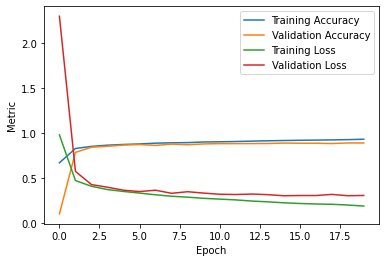

In [30]:
start_time = datetime.now()

baseline_model_generator.fit(trainLoader, validateLoader, 20)
end_time = datetime.now()
baseline_model_generator.Test_Model(testLoader)

print("\nTest Accuracy:", baseline_model_generator.Metrics["Test_Accuracy"], "\nTime to Train:", end_time - start_time)
import matplotlib.pyplot as plt

### PLOTTING METRICS
plt.plot(baseline_model_generator.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(baseline_model_generator.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(baseline_model_generator.Metrics['Training_Loss'], label='Training Loss')
plt.plot(baseline_model_generator.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### Does your network need more epochs for full training? Do you observe overfitting?
We see that the validation loss hasn't shown any major change over the 20 epochs where as the training loss has reduced which means that the model is performing better on the training dataset but not the validation dataset resulting in overfitting.


### 1.b This time add weight penalties (weight decays) 

100%|██████████| 188/188 [00:16<00:00, 11.08it/s]

Current Epoch: 1
Training_Loss: 1.1465635033363992  | Validation_Loss: 2.3028638971612807
Training_Accuracy: 0.6095291972160339  | Validation_Accuracy: 0.09875617176294327



100%|██████████| 188/188 [00:15<00:00, 12.09it/s]

Current Epoch: 2
Training_Loss: 0.6580483301522884  | Validation_Loss: 0.6861382545308864
Training_Accuracy: 0.7734197378158569  | Validation_Accuracy: 0.7577503323554993



100%|██████████| 188/188 [00:15<00:00, 11.86it/s]

Current Epoch: 3
Training_Loss: 0.6179198418208893  | Validation_Loss: 0.6206900249136255
Training_Accuracy: 0.7905428409576416  | Validation_Accuracy: 0.7907092571258545



100%|██████████| 188/188 [00:15<00:00, 11.84it/s]

Current Epoch: 4
Training_Loss: 0.6050974095755435  | Validation_Loss: 0.6188060527152204
Training_Accuracy: 0.7980546951293945  | Validation_Accuracy: 0.7922614216804504



100%|██████████| 188/188 [00:15<00:00, 11.83it/s]

Current Epoch: 5
Training_Loss: 0.5976350981187313  | Validation_Loss: 0.613170843175117
Training_Accuracy: 0.8005542159080505  | Validation_Accuracy: 0.7910300493240356



100%|██████████| 188/188 [00:15<00:00, 12.14it/s]

Current Epoch: 6
Training_Loss: 0.5931078466646215  | Validation_Loss: 0.5884197626976256
Training_Accuracy: 0.8003473281860352  | Validation_Accuracy: 0.8027032017707825



100%|██████████| 188/188 [00:16<00:00, 11.70it/s]

Current Epoch: 7
Training_Loss: 0.5819681383510853  | Validation_Loss: 0.5915373950562579
Training_Accuracy: 0.8058554530143738  | Validation_Accuracy: 0.8037493824958801



100%|██████████| 188/188 [00:16<00:00, 11.63it/s]

Current Epoch: 8
Training_Loss: 0.5786092897995989  | Validation_Loss: 0.5805665704798191
Training_Accuracy: 0.8061725497245789  | Validation_Accuracy: 0.8026530742645264



100%|██████████| 188/188 [00:16<00:00, 11.70it/s]

Current Epoch: 9
Training_Loss: 0.5758918439771267  | Validation_Loss: 0.5735672503075702
Training_Accuracy: 0.8074502944946289  | Validation_Accuracy: 0.8042299151420593



100%|██████████| 188/188 [00:15<00:00, 11.99it/s]

Current Epoch: 10
Training_Loss: 0.5741452056359737  | Validation_Loss: 0.558238612210497
Training_Accuracy: 0.8082168102264404  | Validation_Accuracy: 0.8182962536811829



100%|██████████| 188/188 [00:16<00:00, 11.13it/s]

Current Epoch: 11
Training_Loss: 0.5717310689865275  | Validation_Loss: 0.563083828129667
Training_Accuracy: 0.8102288842201233  | Validation_Accuracy: 0.820304274559021



100%|██████████| 188/188 [00:15<00:00, 11.98it/s]

Current Epoch: 12
Training_Loss: 0.5729720673345505  | Validation_Loss: 0.5643037766852277
Training_Accuracy: 0.8090290427207947  | Validation_Accuracy: 0.8098434209823608



100%|██████████| 188/188 [00:16<00:00, 11.60it/s]


Current Epoch: 13
Training_Loss: 0.5753933150083461  | Validation_Loss: 0.5625613915159348
Training_Accuracy: 0.8067353367805481  | Validation_Accuracy: 0.8186438679695129


100%|██████████| 188/188 [00:15<00:00, 12.03it/s]

Current Epoch: 14
Training_Loss: 0.5728143547126587  | Validation_Loss: 0.5828058542089259
Training_Accuracy: 0.8095617890357971  | Validation_Accuracy: 0.7972118258476257



100%|██████████| 188/188 [00:15<00:00, 12.17it/s]

Current Epoch: 15
Training_Loss: 0.5705744034432351  | Validation_Loss: 0.5604453143921304
Training_Accuracy: 0.8107268214225769  | Validation_Accuracy: 0.8144452571868896



100%|██████████| 188/188 [00:15<00:00, 12.27it/s]

Current Epoch: 16
Training_Loss: 0.5667620493059463  | Validation_Loss: 0.5624140678568089
Training_Accuracy: 0.8122157454490662  | Validation_Accuracy: 0.8136430382728577



100%|██████████| 188/188 [00:15<00:00, 11.93it/s]

Current Epoch: 17
Training_Loss: 0.57120179765402  | Validation_Loss: 0.5665155611139663
Training_Accuracy: 0.8094204068183899  | Validation_Accuracy: 0.8144043684005737



100%|██████████| 188/188 [00:15<00:00, 12.44it/s]

Current Epoch: 18
Training_Loss: 0.5662023550335397  | Validation_Loss: 0.5573242775937344
Training_Accuracy: 0.809871256351471  | Validation_Accuracy: 0.8171705007553101



100%|██████████| 188/188 [00:15<00:00, 11.92it/s]

Current Epoch: 19
Training_Loss: 0.5680111595924865  | Validation_Loss: 0.5780083004464495
Training_Accuracy: 0.812155544757843  | Validation_Accuracy: 0.7945097088813782



100%|██████████| 188/188 [00:15<00:00, 12.20it/s]

Current Epoch: 20
Training_Loss: 0.5666168165650773  | Validation_Loss: 0.5688659301463593
Training_Accuracy: 0.8115618228912354  | Validation_Accuracy: 0.8049185872077942



Test Accuracy: 0.7989999651908875 
Time taken to Train: 0:06:28.961628


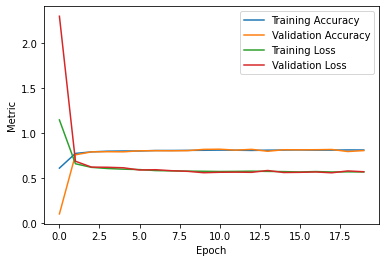

In [31]:

weight_model = copy.deepcopy(BaseModel)
weight_penalty_model = Train_Model(weight_model, nn.CrossEntropyLoss(), torch.optim.SGD(weight_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.05), MulticlassAccuracy, "Classification",  device_to_use, 10)

start_time = datetime.now()

weight_penalty_model.fit(trainLoader, validateLoader, 20)
end_time = datetime.now()
weight_penalty_model.Test_Model(testLoader)

print("\nTest Accuracy:", weight_penalty_model.Metrics["Test_Accuracy"], "\nTime taken to Train:", end_time - start_time)

### PLOTTING METRICS
plt.plot(weight_penalty_model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(weight_penalty_model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(weight_penalty_model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(weight_penalty_model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### How do the training results change compared to the baseline?

Although both the baseline graph and weight added model graph seem to show similar performance, we observe a noticable gap difference in the weight added model between the training and validation accuracy compared to the baseline model and by observing both the results we can say that adding the weight decay did reduce the issue of overfitting our model. For our purpose, we considered the weight_decay as 0.05 and this can be played around to evaulate the model performance.


### 1.c This time add dropout (dropout = 0.3)

In [32]:
Drop_out = copy.deepcopy(BaseModel)
Drop_out.insert(5, nn.Dropout(0.3))
Drop_out.insert(8, nn.Dropout(0.3))
print(Drop_out)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): LazyLinear(in_features=0, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:16<00:00, 11.56it/s]

Current Epoch: 1
Training_Loss: 1.166381965609307  | Validation_Loss: 2.308890926077011
Training_Accuracy: 0.5760897994041443  | Validation_Accuracy: 0.10030808299779892



100%|██████████| 188/188 [00:16<00:00, 11.42it/s]


Current Epoch: 2
Training_Loss: 0.5872640058081201  | Validation_Loss: 0.5720512188495473
Training_Accuracy: 0.7894220352172852  | Validation_Accuracy: 0.7837074995040894


100%|██████████| 188/188 [00:15<00:00, 11.89it/s]

Current Epoch: 3
Training_Loss: 0.4953218444864801  | Validation_Loss: 0.45259577352949915
Training_Accuracy: 0.8255534768104553  | Validation_Accuracy: 0.8344342112541199



100%|██████████| 188/188 [00:15<00:00, 12.00it/s]

Current Epoch: 4
Training_Loss: 0.4487860104505052  | Validation_Loss: 0.40953093703756943
Training_Accuracy: 0.8429778814315796  | Validation_Accuracy: 0.8511654734611511



100%|██████████| 188/188 [00:15<00:00, 12.05it/s]

Current Epoch: 5
Training_Loss: 0.42031944146815764  | Validation_Loss: 0.39410736903231197
Training_Accuracy: 0.8524385094642639  | Validation_Accuracy: 0.851655125617981



100%|██████████| 188/188 [00:15<00:00, 11.93it/s]

Current Epoch: 6
Training_Loss: 0.397916408770896  | Validation_Loss: 0.37485564008672184
Training_Accuracy: 0.8612020611763  | Validation_Accuracy: 0.8604258894920349



100%|██████████| 188/188 [00:15<00:00, 12.19it/s]

Current Epoch: 7
Training_Loss: 0.3792966255482207  | Validation_Loss: 0.36627969082365647
Training_Accuracy: 0.867420494556427  | Validation_Accuracy: 0.8682668209075928



100%|██████████| 188/188 [00:16<00:00, 11.71it/s]

Current Epoch: 8
Training_Loss: 0.3627786678361132  | Validation_Loss: 0.3541715167304303
Training_Accuracy: 0.8730224370956421  | Validation_Accuracy: 0.8695382475852966



100%|██████████| 188/188 [00:15<00:00, 11.82it/s]


Current Epoch: 9
Training_Loss: 0.3503030892857846  | Validation_Loss: 0.3426747334764359
Training_Accuracy: 0.8768774271011353  | Validation_Accuracy: 0.8703455924987793


100%|██████████| 188/188 [00:16<00:00, 11.46it/s]


Current Epoch: 10
Training_Loss: 0.33657630350678525  | Validation_Loss: 0.33804376803814096
Training_Accuracy: 0.8837140798568726  | Validation_Accuracy: 0.8758836984634399


100%|██████████| 188/188 [00:15<00:00, 12.12it/s]

Current Epoch: 11
Training_Loss: 0.3254699383644348  | Validation_Loss: 0.34516935843102475
Training_Accuracy: 0.8869490027427673  | Validation_Accuracy: 0.8726597428321838



100%|██████████| 188/188 [00:15<00:00, 12.01it/s]

Current Epoch: 12
Training_Loss: 0.3134230279383507  | Validation_Loss: 0.32459806730138496
Training_Accuracy: 0.8900049924850464  | Validation_Accuracy: 0.8808032274246216



100%|██████████| 188/188 [00:15<00:00, 12.16it/s]

Current Epoch: 13
Training_Loss: 0.3046234538580509  | Validation_Loss: 0.330621397241633
Training_Accuracy: 0.89347904920578  | Validation_Accuracy: 0.8758515119552612



100%|██████████| 188/188 [00:15<00:00, 12.04it/s]

Current Epoch: 14
Training_Loss: 0.29498989491703664  | Validation_Loss: 0.32503492115659915
Training_Accuracy: 0.8969369530677795  | Validation_Accuracy: 0.8774777054786682



100%|██████████| 188/188 [00:15<00:00, 11.93it/s]

Current Epoch: 15
Training_Loss: 0.28611915891474865  | Validation_Loss: 0.32069388887983685
Training_Accuracy: 0.8987576365470886  | Validation_Accuracy: 0.8820980191230774



100%|██████████| 188/188 [00:15<00:00, 12.06it/s]

Current Epoch: 16
Training_Loss: 0.2809142031251116  | Validation_Loss: 0.3111833498833027
Training_Accuracy: 0.9019501805305481  | Validation_Accuracy: 0.8856874704360962



100%|██████████| 188/188 [00:15<00:00, 11.81it/s]

Current Epoch: 17
Training_Loss: 0.2729464811371996  | Validation_Loss: 0.31234482723347684
Training_Accuracy: 0.9041261076927185  | Validation_Accuracy: 0.8864128589630127



100%|██████████| 188/188 [00:15<00:00, 11.99it/s]

Current Epoch: 18
Training_Loss: 0.26121943776911877  | Validation_Loss: 0.31025107743892266
Training_Accuracy: 0.9064929485321045  | Validation_Accuracy: 0.8874361515045166



100%|██████████| 188/188 [00:16<00:00, 11.57it/s]

Current Epoch: 19
Training_Loss: 0.2582324376290149  | Validation_Loss: 0.3104593484325612
Training_Accuracy: 0.9086595773696899  | Validation_Accuracy: 0.8877584338188171



100%|██████████| 188/188 [00:15<00:00, 11.93it/s]

Current Epoch: 20
Training_Loss: 0.25425497426631605  | Validation_Loss: 0.3131451885750953
Training_Accuracy: 0.9107547402381897  | Validation_Accuracy: 0.8858952522277832



Test Accuracy: 0.8799999952316284 
Time Taken to Train: 0:06:27.701476


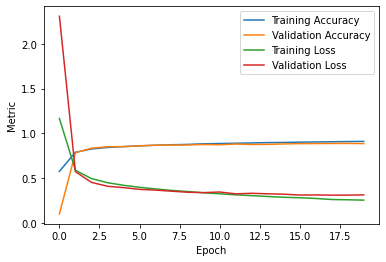

In [33]:
dropout_model = Train_Model(Drop_out, nn.CrossEntropyLoss(), torch.optim.SGD(Drop_out.parameters(), lr=0.01, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

start_time = datetime.now()

dropout_model.fit(trainLoader, validateLoader, 20)
end_time = datetime.now()
dropout_model.Test_Model(testLoader)

print("\nTest Accuracy:", dropout_model.Metrics["Test_Accuracy"], "\nTime Taken to Train:", end_time - start_time)

### PLOTTING METRICS
plt.plot(dropout_model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(dropout_model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(dropout_model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(dropout_model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()


### How do the training results change compared to the previous two models?

This time, both the training and validation accuracies have improved compared to the baseline and weighted_decay models. Tuning the dropout helped the model in reducing the generalization gap between training and validation making the results better.

### 1.d Repeat problems 1.b and 1.c; This time, load the pre-trained parameters from the storage

In [34]:
PretrainedModel = copy.deepcopy(baseline_model_generator.model)
PretrainedModel.insert(5, nn.Dropout(0.3))
PretrainedModel.insert(8, nn.Dropout(0.3))
print(PretrainedModel)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:16<00:00, 11.69it/s]

Current Epoch: 1
Training_Loss: 0.46707451089899593  | Validation_Loss: 0.30776472770153207
Training_Accuracy: 0.8490539789199829  | Validation_Accuracy: 0.8878763318061829



100%|██████████| 188/188 [00:15<00:00, 12.28it/s]

Current Epoch: 2
Training_Loss: 0.6254348517098325  | Validation_Loss: 0.48360371970115823
Training_Accuracy: 0.8008111119270325  | Validation_Accuracy: 0.8404088020324707



100%|██████████| 188/188 [00:16<00:00, 11.55it/s]

Current Epoch: 3
Training_Loss: 0.6487870114914914  | Validation_Loss: 0.558657392542413
Training_Accuracy: 0.7905000448226929  | Validation_Accuracy: 0.8204336762428284



100%|██████████| 188/188 [00:15<00:00, 12.10it/s]

Current Epoch: 4
Training_Loss: 0.6513172927054953  | Validation_Loss: 0.5815457086613838
Training_Accuracy: 0.7863602042198181  | Validation_Accuracy: 0.8066273331642151



100%|██████████| 188/188 [00:15<00:00, 12.04it/s]

Current Epoch: 5
Training_Loss: 0.6441115232858252  | Validation_Loss: 0.5701603838737975
Training_Accuracy: 0.7915712594985962  | Validation_Accuracy: 0.8110802173614502



100%|██████████| 188/188 [00:15<00:00, 11.93it/s]

Current Epoch: 6
Training_Loss: 0.6411333248970357  | Validation_Loss: 0.567690483433135
Training_Accuracy: 0.7934460043907166  | Validation_Accuracy: 0.8124362230300903



100%|██████████| 188/188 [00:15<00:00, 12.19it/s]

Current Epoch: 7
Training_Loss: 0.6388204576487236  | Validation_Loss: 0.562303474608888
Training_Accuracy: 0.7907006144523621  | Validation_Accuracy: 0.8145942687988281



100%|██████████| 188/188 [00:15<00:00, 11.84it/s]

Current Epoch: 8
Training_Loss: 0.6369883757322392  | Validation_Loss: 0.5661652081824363
Training_Accuracy: 0.7905989289283752  | Validation_Accuracy: 0.8055729866027832



100%|██████████| 188/188 [00:15<00:00, 12.32it/s]

Current Epoch: 9
Training_Loss: 0.6367460955330666  | Validation_Loss: 0.5622074623057183
Training_Accuracy: 0.790971577167511  | Validation_Accuracy: 0.8146941661834717



100%|██████████| 188/188 [00:15<00:00, 12.18it/s]

Current Epoch: 10
Training_Loss: 0.6404041007478186  | Validation_Loss: 0.5751925643454207
Training_Accuracy: 0.7886437773704529  | Validation_Accuracy: 0.8000040054321289



100%|██████████| 188/188 [00:15<00:00, 12.17it/s]

Current Epoch: 11
Training_Loss: 0.6367578988379621  | Validation_Loss: 0.5555111467838287
Training_Accuracy: 0.7917004823684692  | Validation_Accuracy: 0.8160396218299866



100%|██████████| 188/188 [00:15<00:00, 12.15it/s]

Current Epoch: 12
Training_Loss: 0.6366805580068142  | Validation_Loss: 0.5688573546866154
Training_Accuracy: 0.7903964519500732  | Validation_Accuracy: 0.8087551593780518



100%|██████████| 188/188 [00:16<00:00, 11.66it/s]

Current Epoch: 13
Training_Loss: 0.6391166099842559  | Validation_Loss: 0.5733889265263334
Training_Accuracy: 0.7899972796440125  | Validation_Accuracy: 0.8063159584999084



100%|██████████| 188/188 [00:16<00:00, 11.66it/s]

Current Epoch: 14
Training_Loss: 0.6327658393915664  | Validation_Loss: 0.560727706614961
Training_Accuracy: 0.7939309477806091  | Validation_Accuracy: 0.8181354403495789



100%|██████████| 188/188 [00:15<00:00, 11.90it/s]

Current Epoch: 15
Training_Loss: 0.6358336904581557  | Validation_Loss: 0.5650885168542253
Training_Accuracy: 0.7920455932617188  | Validation_Accuracy: 0.8128567934036255



100%|██████████| 188/188 [00:15<00:00, 12.09it/s]


Current Epoch: 16
Training_Loss: 0.6395877041715257  | Validation_Loss: 0.5780487999002984
Training_Accuracy: 0.7897927165031433  | Validation_Accuracy: 0.8046083450317383


100%|██████████| 188/188 [00:16<00:00, 11.42it/s]

Current Epoch: 17
Training_Loss: 0.635272242921464  | Validation_Loss: 0.5738013595976728
Training_Accuracy: 0.7916228175163269  | Validation_Accuracy: 0.8023495078086853



100%|██████████| 188/188 [00:15<00:00, 12.05it/s]


Current Epoch: 18
Training_Loss: 0.6327496411952567  | Validation_Loss: 0.568142572616009
Training_Accuracy: 0.7933149337768555  | Validation_Accuracy: 0.8136730790138245


100%|██████████| 188/188 [00:15<00:00, 11.84it/s]

Current Epoch: 19
Training_Loss: 0.6359841512872818  | Validation_Loss: 0.5617164075374603
Training_Accuracy: 0.7913767099380493  | Validation_Accuracy: 0.8142700791358948



100%|██████████| 188/188 [00:15<00:00, 12.17it/s]

Current Epoch: 20
Training_Loss: 0.6342317690240576  | Validation_Loss: 0.575435591504929
Training_Accuracy: 0.7935135960578918  | Validation_Accuracy: 0.8072612881660461



Test Accuracy: 0.8004000186920166 
Time Taken to Train: 0:06:25.850510


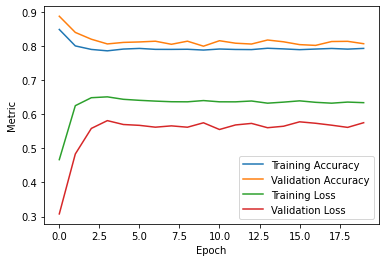

In [35]:
PretrainedModelTrainer = Train_Model(PretrainedModel, nn.CrossEntropyLoss(), torch.optim.SGD(PretrainedModel.parameters(), lr=0.01, momentum=0.9, weight_decay=0.05), MulticlassAccuracy, "Classification", device_to_use, 10)

start_time = datetime.now()

PretrainedModelTrainer.fit(trainLoader, validateLoader, 20)
end_time = datetime.now()
PretrainedModelTrainer.Test_Model(testLoader)

print("\nTest Accuracy:", PretrainedModelTrainer.Metrics["Test_Accuracy"], "\nTime Taken to Train:", end_time - start_time)

### PLOTTING METRICS
plt.plot(PretrainedModelTrainer.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(PretrainedModelTrainer.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(PretrainedModelTrainer.Metrics['Training_Loss'], label='Training Loss')
plt.plot(PretrainedModelTrainer.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### Compare the training time and number of epochs needed against 1.b and 1.c.
Time taken by baseline model -- 6:41
Time taken by Weight Decay model -- 6:28
Time taken by Drop Out model -- 6:27
Time taken by Pre-Trained model -- 6:25

The training taken by baseline model was higher by around 20 seconds when compared to other models. The rest 3 models appear to have taken similar time taken to train.
The base model and the dropout model took similar number of epochs whereas the decay required more number of epochs to converge.

## Problem 2 Housing Predictions

In [36]:
device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
train_df = pd.read_csv("/content/datasets/Housing Data/train.csv")
test_df = pd.read_csv("/content/datasets/Housing Data/test.csv")
display(train_df.head()),display(test_df.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


(None, None)

### 2.a What happens if we need to standardize the continuous numerical features?
Standardizing the data helps in fixing missing values or correcting incorrect data which includes having textual informaiton in numerical column or such similar cases. Upon standardizing, the model understands the data better and makes better predictions.

In [38]:
def data_preprocessor(train_data, test_data, label='SalePrice'):
    
    features_all = pd.concat((train_data.drop(columns=['Id', label]), test_data.drop(columns=['Id'])))
    numeric_features = features_all.dtypes[features_all.dtypes != 'object'].index
    
    features_all[numeric_features] = features_all[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
    features_all[numeric_features] = features_all[numeric_features].fillna(0)
    features_all = pd.get_dummies(features_all, dummy_na=True)
    
    train_df = features_all[:train_data.shape[0]].copy()
    
    normVals = (train_data[label].mean(), train_data[label].std())
    print(normVals)
    
    train_df[label] = ( train_data[label] - normVals[0] ) / normVals[1]
    test_df = features_all[train_data.shape[0]:].copy()
    
    return train_df, test_df

In [39]:
train_processed_df, test_processed_df = data_preprocessor(train_df, test_df)
test_processed_df.head()

(180921.19589041095, 79442.50288288662)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,-0.873466,0.458096,0.184340,-0.772420,0.391170,-0.340452,-1.113434,-0.569893,0.058332,0.558006,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.500932,0.519702,-0.063174,0.391170,-0.439490,-1.257014,0.032335,1.056991,-0.293030,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,0.201080,0.464294,-0.772420,-0.507197,0.848003,0.657380,-0.569893,0.767271,-0.293030,...,0,1,0,0,0,0,0,1,0,0
3,0.067320,0.372424,-0.024105,-0.063174,0.391170,0.881015,0.657380,-0.458369,0.352443,-0.293030,...,0,1,0,0,0,0,0,1,0,0
4,1.478499,-1.126832,-0.654636,1.355319,-0.507197,0.682939,0.370221,-0.569893,-0.391613,-0.293030,...,0,1,0,0,0,0,0,1,0,0


In [40]:
lectureModel = nn.Sequential(
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(10),
)


class sale_predictor(nn.Module):
    def __init__(self):
        super(sale_predictor, self).__init__()
        
        # From output data 
        self.mean = 180921.19589041095
        self.std = 79442.50288288662
        self.unNormalize = False    
        self.Dropout = False
        self.D1 = nn.Dropout(0.3)
        
        self.layer1 = nn.LazyLinear(256)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.LazyLinear(256)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.LazyLinear(128)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.LazyLinear(1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)  
        x = self.relu2(x)
        if self.Dropout:
            x = self.D1(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)
        
        if self.unNormalize:
            x = x * self.std + self.mean
        
        return x

sale_predictor = sale_predictor()

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [41]:
class housing_dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        dimensions = torch.Tensor(row.values)
        label = dimensions[-1]
        
        return (dimensions[:-1], label)

In [43]:
train_housing = housing_dataset(train_processed_df)

validNum = int(len(train_housing) * 0.8)
train_housing, valid_housing = random_split(train_housing, [validNum, len(train_housing) - validNum])

trainLoaderHousing = DataLoader(train_housing, batch_size=128, shuffle=True, num_workers=0)
validateLoaderHousing = DataLoader(valid_housing, batch_size=128, shuffle=True, num_workers=0)

### 2.b Improve the score by improving the model complexity

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([36, 1])) that is different to the input size (torch.Size([36, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 80%|████████  | 8/10 [00:00<00:00, 15.32it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please e

Current Epoch: 1
Training_Loss: 0.9198947429656983  | Validation_Loss: 1.071117063363393


100%|██████████| 10/10 [00:01<00:00,  9.88it/s]


Current Epoch: 2
Training_Loss: 0.6371375858783722  | Validation_Loss: 1.0388497908910115


100%|██████████| 10/10 [00:01<00:00,  9.56it/s]


Current Epoch: 3
Training_Loss: 0.2671642392873764  | Validation_Loss: 0.5765660554170609


100%|██████████| 10/10 [00:00<00:00, 10.97it/s]


Current Epoch: 4
Training_Loss: 0.23329071700572968  | Validation_Loss: 0.19700143237908682


100%|██████████| 10/10 [00:00<00:00, 16.65it/s]


Current Epoch: 5
Training_Loss: 0.18514424413442612  | Validation_Loss: 0.2925560896595319


100%|██████████| 10/10 [00:00<00:00, 17.22it/s]


Current Epoch: 6
Training_Loss: 0.2019464962184429  | Validation_Loss: 0.15113641818364462


100%|██████████| 10/10 [00:00<00:00, 17.19it/s]


Current Epoch: 7
Training_Loss: 0.1513876162469387  | Validation_Loss: 0.1578351060549418


100%|██████████| 10/10 [00:00<00:00, 17.31it/s]


Current Epoch: 8
Training_Loss: 0.15574345961213112  | Validation_Loss: 0.2875954732298851


100%|██████████| 10/10 [00:00<00:00, 16.65it/s]


Current Epoch: 9
Training_Loss: 0.2451399512588978  | Validation_Loss: 0.16933531314134598


100%|██████████| 10/10 [00:00<00:00, 17.51it/s]


Current Epoch: 10
Training_Loss: 0.14700731113553048  | Validation_Loss: 0.16829424848159155


100%|██████████| 10/10 [00:00<00:00, 17.88it/s]


Current Epoch: 11
Training_Loss: 0.15243006646633148  | Validation_Loss: 0.19563174496094385


100%|██████████| 10/10 [00:00<00:00, 16.80it/s]


Current Epoch: 12
Training_Loss: 0.15529733821749686  | Validation_Loss: 0.1669458051522573


100%|██████████| 10/10 [00:00<00:00, 16.82it/s]


Current Epoch: 13
Training_Loss: 0.1765695370733738  | Validation_Loss: 0.16368776063124338


100%|██████████| 10/10 [00:00<00:00, 16.95it/s]


Current Epoch: 14
Training_Loss: 0.12116245087236166  | Validation_Loss: 0.3449222519993782


100%|██████████| 10/10 [00:00<00:00, 16.74it/s]


Current Epoch: 15
Training_Loss: 0.11302256602793932  | Validation_Loss: 0.1713611682256063


100%|██████████| 10/10 [00:00<00:00, 17.04it/s]


Current Epoch: 16
Training_Loss: 0.13218890726566315  | Validation_Loss: 0.33310683568318683


100%|██████████| 10/10 [00:00<00:00, 16.72it/s]


Current Epoch: 17
Training_Loss: 0.10431664362549782  | Validation_Loss: 0.1490122377872467


100%|██████████| 10/10 [00:00<00:00, 10.89it/s]


Current Epoch: 18
Training_Loss: 0.10194049403071404  | Validation_Loss: 0.17685812711715698


100%|██████████| 10/10 [00:00<00:00, 10.28it/s]


Current Epoch: 19
Training_Loss: 0.09943705722689629  | Validation_Loss: 0.1744967537621657


100%|██████████| 10/10 [00:01<00:00,  9.87it/s]


Current Epoch: 20
Training_Loss: 0.09355470407754182  | Validation_Loss: 0.1528907207151254
Time Taken to Train: 0:00:17.719959


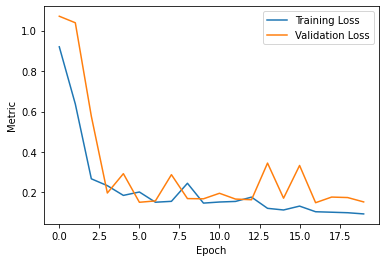

In [44]:

LectureModel = copy.deepcopy(lectureModel)
LectureHousingTrainer = Train_Model(LectureModel, nn.MSELoss(), torch.optim.SGD(LectureModel.parameters(), lr=0.01, momentum=0.9), nn.MSELoss(), "Regression",  device_to_use)

start_time = datetime.now()

LectureHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, 20)
end_time = datetime.now()

print("Time Taken to Train:", end_time - start_time)
### PLOTTING METRICS
plt.plot(LectureHousingTrainer.Metrics['Training_Loss'], label='Training Loss')
plt.plot(LectureHousingTrainer.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

100%|██████████| 10/10 [00:00<00:00, 14.51it/s]


Current Epoch: 1
Training_Loss: 0.9514143347740174  | Validation_Loss: 0.9275064667065939


100%|██████████| 10/10 [00:00<00:00, 15.60it/s]


Current Epoch: 2
Training_Loss: 0.8124876350164414  | Validation_Loss: 1.2978623112042744


100%|██████████| 10/10 [00:00<00:00, 16.22it/s]


Current Epoch: 3
Training_Loss: 0.4353019595146179  | Validation_Loss: 0.6165536244710287


100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


Current Epoch: 4
Training_Loss: 0.24809769317507743  | Validation_Loss: 0.24658953646818796


100%|██████████| 10/10 [00:00<00:00, 15.83it/s]


Current Epoch: 5
Training_Loss: 0.20031529515981675  | Validation_Loss: 0.16455749670664468


100%|██████████| 10/10 [00:00<00:00, 15.92it/s]


Current Epoch: 6
Training_Loss: 0.16331703141331672  | Validation_Loss: 0.1674443483352661


100%|██████████| 10/10 [00:00<00:00, 17.20it/s]


Current Epoch: 7
Training_Loss: 0.124736069701612  | Validation_Loss: 0.15187754730383554


100%|██████████| 10/10 [00:00<00:00, 15.89it/s]


Current Epoch: 8
Training_Loss: 0.12147986181080342  | Validation_Loss: 0.16573123882214227


100%|██████████| 10/10 [00:00<00:00, 16.62it/s]


Current Epoch: 9
Training_Loss: 0.10719092823565006  | Validation_Loss: 0.3732186978061994


100%|██████████| 10/10 [00:00<00:00, 17.33it/s]


Current Epoch: 10
Training_Loss: 0.0982021726667881  | Validation_Loss: 0.3965868254502614


100%|██████████| 10/10 [00:00<00:00, 17.30it/s]


Current Epoch: 11
Training_Loss: 0.09641841165721417  | Validation_Loss: 0.18781508008639017


100%|██████████| 10/10 [00:00<00:00, 16.78it/s]


Current Epoch: 12
Training_Loss: 0.08817586861550808  | Validation_Loss: 0.16594144701957703


100%|██████████| 10/10 [00:00<00:00, 11.96it/s]


Current Epoch: 13
Training_Loss: 0.07840017601847649  | Validation_Loss: 0.4167405962944031


100%|██████████| 10/10 [00:01<00:00,  9.66it/s]


Current Epoch: 14
Training_Loss: 0.07554927729070186  | Validation_Loss: 0.16355781132976213


100%|██████████| 10/10 [00:01<00:00,  9.73it/s]


Current Epoch: 15
Training_Loss: 0.06921385452151299  | Validation_Loss: 0.16712178538242975


100%|██████████| 10/10 [00:00<00:00, 16.66it/s]


Current Epoch: 16
Training_Loss: 0.06271290164440871  | Validation_Loss: 0.16146436830361685


100%|██████████| 10/10 [00:00<00:00, 16.75it/s]


Current Epoch: 17
Training_Loss: 0.06027549467980862  | Validation_Loss: 0.17459880436460176


100%|██████████| 10/10 [00:00<00:00, 15.86it/s]


Current Epoch: 18
Training_Loss: 0.059041372314095494  | Validation_Loss: 0.1691846332202355


100%|██████████| 10/10 [00:00<00:00, 16.19it/s]


Current Epoch: 19
Training_Loss: 0.056856471300125125  | Validation_Loss: 0.1722014807164669


100%|██████████| 10/10 [00:00<00:00, 16.81it/s]

Current Epoch: 20
Training_Loss: 0.0514498608186841  | Validation_Loss: 0.1628448280195395
Time Taken to Train: 0:00:16.757407


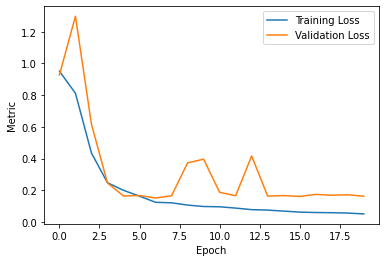

In [45]:
base_housingModel = copy.deepcopy(sale_predictor)
ComplexHousingTrainer = Train_Model(base_housingModel, nn.MSELoss(), torch.optim.SGD(base_housingModel.parameters(), lr=0.01, momentum=0.9), nn.MSELoss(), "Regression",  device_to_use)

start_time = datetime.now()

ComplexHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, 20)
end_time = datetime.now()

print("Time Taken to Train:", end_time - start_time)
### PLOTTING METRICS
plt.plot(ComplexHousingTrainer.Metrics['Training_Loss'], label='Training Loss')
plt.plot(ComplexHousingTrainer.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### How about the model complexity comparison and training time?
The new model shows better accuracy compared to the model built during the class lectures.

### 2.c How about exploring options for weight decay and dropout over the more complex model?

100%|██████████| 10/10 [00:00<00:00, 15.05it/s]


Current Epoch: 1
Training_Loss: 0.9691969871520996  | Validation_Loss: 0.9991535941759745


100%|██████████| 10/10 [00:00<00:00, 15.84it/s]


Current Epoch: 2
Training_Loss: 0.8679753422737122  | Validation_Loss: 0.9552673697471619


100%|██████████| 10/10 [00:00<00:00, 16.45it/s]


Current Epoch: 3
Training_Loss: 0.48570985049009324  | Validation_Loss: 0.609295388062795


100%|██████████| 10/10 [00:00<00:00, 16.29it/s]


Current Epoch: 4
Training_Loss: 0.26208523809909823  | Validation_Loss: 0.17429418365160623


100%|██████████| 10/10 [00:00<00:00, 16.17it/s]


Current Epoch: 5
Training_Loss: 0.2039308100938797  | Validation_Loss: 0.16149225334326425


100%|██████████| 10/10 [00:00<00:00, 16.67it/s]


Current Epoch: 6
Training_Loss: 0.1709236152470112  | Validation_Loss: 0.18622806668281555


100%|██████████| 10/10 [00:00<00:00, 16.46it/s]


Current Epoch: 7
Training_Loss: 0.1634316064417362  | Validation_Loss: 0.14672658095757166


100%|██████████| 10/10 [00:00<00:00, 12.82it/s]


Current Epoch: 8
Training_Loss: 0.15484301820397378  | Validation_Loss: 0.14415173480908075


100%|██████████| 10/10 [00:01<00:00,  9.56it/s]


Current Epoch: 9
Training_Loss: 0.15774493142962456  | Validation_Loss: 0.16928462187449136


100%|██████████| 10/10 [00:01<00:00,  9.68it/s]


Current Epoch: 10
Training_Loss: 0.1205511212348938  | Validation_Loss: 0.1646832376718521


100%|██████████| 10/10 [00:00<00:00, 13.46it/s]


Current Epoch: 11
Training_Loss: 0.12446224763989448  | Validation_Loss: 0.35016660888989765


100%|██████████| 10/10 [00:00<00:00, 17.01it/s]


Current Epoch: 12
Training_Loss: 0.1654038317501545  | Validation_Loss: 0.1898132860660553


100%|██████████| 10/10 [00:00<00:00, 16.84it/s]


Current Epoch: 13
Training_Loss: 0.1289200283586979  | Validation_Loss: 0.1678774654865265


100%|██████████| 10/10 [00:00<00:00, 16.89it/s]


Current Epoch: 14
Training_Loss: 0.10277911499142647  | Validation_Loss: 0.1866726204752922


100%|██████████| 10/10 [00:00<00:00, 16.96it/s]


Current Epoch: 15
Training_Loss: 0.09323706179857254  | Validation_Loss: 0.17103929072618484


100%|██████████| 10/10 [00:00<00:00, 16.24it/s]


Current Epoch: 16
Training_Loss: 0.09333149418234825  | Validation_Loss: 0.16325588275988898


100%|██████████| 10/10 [00:00<00:00, 17.21it/s]


Current Epoch: 17
Training_Loss: 0.09191130138933659  | Validation_Loss: 0.16675173615415892


100%|██████████| 10/10 [00:00<00:00, 16.23it/s]


Current Epoch: 18
Training_Loss: 0.08790843822062015  | Validation_Loss: 0.1615052248040835


100%|██████████| 10/10 [00:00<00:00, 17.06it/s]


Current Epoch: 19
Training_Loss: 0.08366970308125019  | Validation_Loss: 0.15990135570367178


100%|██████████| 10/10 [00:00<00:00, 17.28it/s]


Current Epoch: 20
Training_Loss: 0.08029063791036606  | Validation_Loss: 0.15844229981303215
Time Taken to Train: 0:00:16.727856


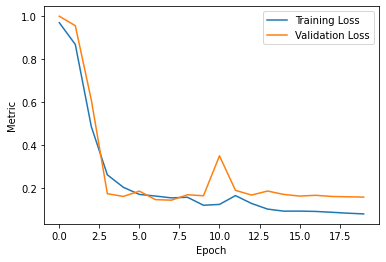

In [46]:
drop_decay_housingModel = copy.deepcopy(sale_predictor)
drop_decay_housingModel.Dropout = True

DropHousingTrainer = Train_Model(drop_decay_housingModel, nn.MSELoss(), torch.optim.SGD(drop_decay_housingModel.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001), nn.MSELoss(), "Regression",  device_to_use)

start_time = datetime.now()

DropHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, 20)
end_time = datetime.now()

print("Time Taken to Train:", end_time - start_time)
### PLOTTING METRICS
plt.plot(DropHousingTrainer.Metrics['Training_Loss'], label='Training Loss')
plt.plot(DropHousingTrainer.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### Please plot the results and compare them against 2.b
The loss patterns looks similar in both 2.b and 2.c

In [47]:
DropHousingTrainer.model.Dropout = False
DropHousingTrainer.model.unNormalize = True
torch.save(DropHousingTrainer.model.state_dict(), 'DropHousing.pt')

In [48]:
preds = torch.tensor(test_processed_df.values, dtype=torch.float32)
print(preds.shape)
DropHousingTrainer.model.eval()
kagglePredictions = DropHousingTrainer.model(preds).reshape(-1)
print(kagglePredictions.shape, test_df.Id.shape)
submission = pd.DataFrame({'Id': test_df.Id,'SalePrice':kagglePredictions.detach().numpy()})
display(submission)
submission.to_csv('submission.csv', index=False)

torch.Size([1459, 331])
torch.Size([1459]) (1459,)


,Id,SalePrice
0,1461,122199.656250
1,1462,151246.718750
2,1463,173351.703125
3,1464,187844.281250
4,1465,191011.734375
...,...,...
1454,2915,94264.726562
1455,2916,97609.359375
1456,2917,167482.484375
1457,2918,118991.140625


### 2.d Kaggle Submission
#### Leadership Rank -- 1527

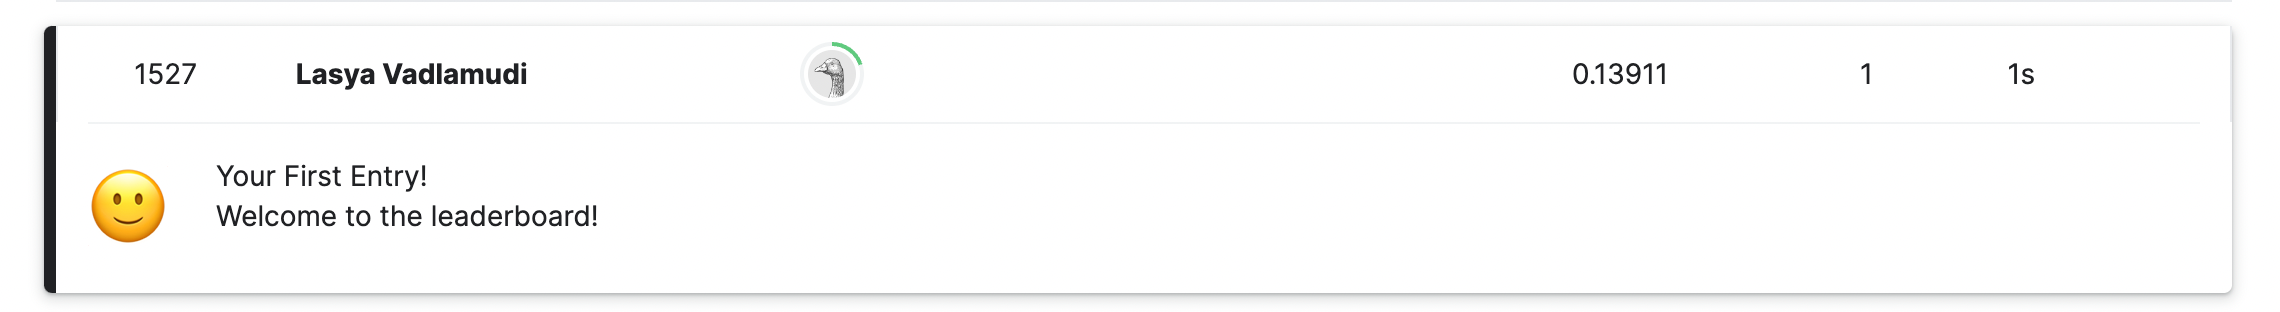